# Visualizing intermediate convnet outputs (intermediate activations)




In this notebook, we show how successive convnet layers transform their input for getting a better idea of the meaning of individual convent filters.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.preprocessing import image

In [4]:
# load model v1: small dataset
model = load_model('dogs_vs_cats_v1.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [5]:
# Listing 5.25
img_path = "sheldon.jpg"
img_path = "hachi.jpg"
img_path = "/media/data/dogs_vs_cats_small/test/dogs/dog.1999.jpg"
img_path = "/media/data/dogs_vs_cats_small/test/cats/cat.1700.jpg"

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)              # shape: (150, 150, 3)
img_tensor = np.expand_dims(img_tensor, axis=0)   # shape: (1, 150, 150, 1)
img_tensor = img_tensor / 255.                    # remember that the model was trained on inputs that were processed this way

<IPython.core.display.Javascript object>


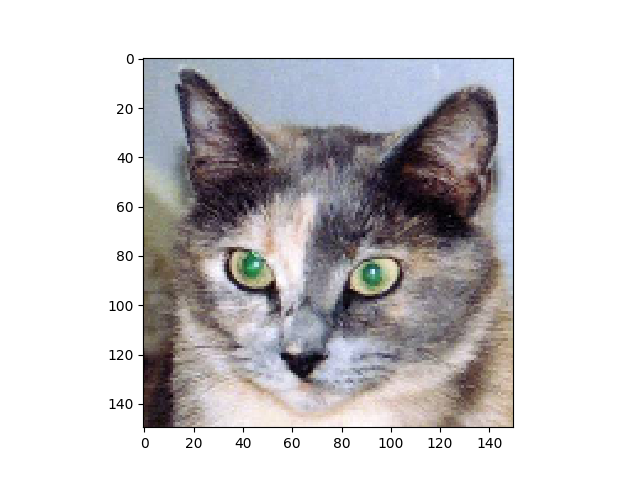

In [6]:
%matplotlib notebook
plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps we want to look at, we will create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. To do this, we will use the Kerasl class `Model`. A model is instatiated using two arguments:
- an input tensor (or list of input tensors)
- an output tensor (of list of output tensors)

The resulting class is a Keras model, just like the `Sequential` models you are familiar with, mapping the specified inputs fo the specified outputs.

In [6]:
# Listing 5.27 Instatiating a model from an input tensor and a list of output tensors
layer_outputs = [layer.output for layer in model.layers[:8]]                 # extract the outputs of the top eight layers
activation_model = models.Model(
                            inputs=model.input,
                            outputs=layer_outputs,
                            )

In [7]:
# Listing 5.28 Running the model in predict mode
activations = activation_model.predict(img_tensor)

`activations` is a list with 8 elements, where each element is a tensor with shape `(1, 148, 148, 32)`:

In [11]:
print("type", type(activations))
print("len", len(activations))
print("type activations[0]", type(activations[0]))
print("shape activations[0]", activations[0].shape)

type <class 'list'>
len 8
type activations[0] <class 'numpy.ndarray'>
shape activations[0] (1, 148, 148, 32)


For instance, this is the activation function of the first convolution layer for the image input:

In [12]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It is a 148x148 feature map with 32 channels. Let's try plotting the fourth channel of the activation of the first layer of the original model: 

<IPython.core.display.Javascript object>


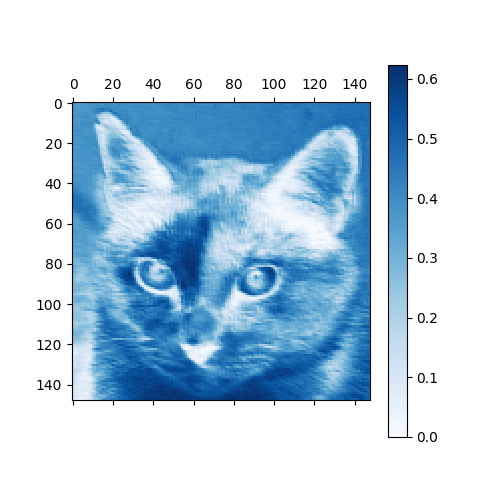

In [18]:
%matplotlib notebook
# Listing 5.29 Visualizing the fourth channel
im = plt.matshow(first_layer_activation[0, :, :, 4], cmap="Blues")
plt.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>


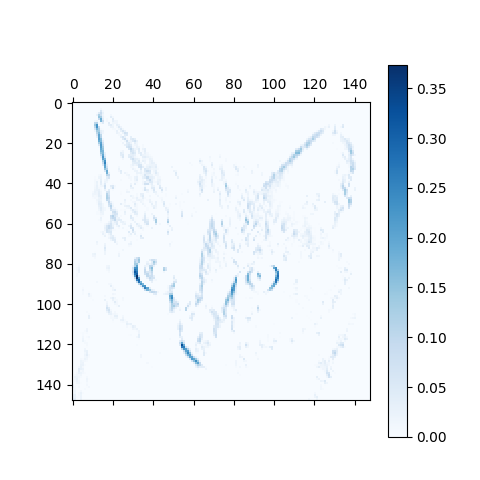

In [19]:
# Listing 5.29 Visualizing the fourth channel
im = plt.matshow(first_layer_activation[0, :, :, 7], cmap="Blues")
plt.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>


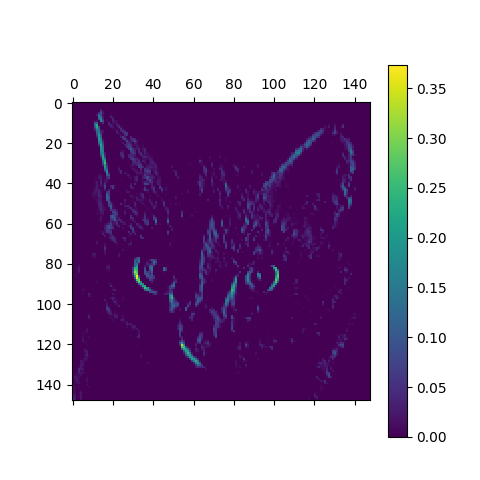

In [20]:
# Listing 5.29 Visualizing the fourth channel
im = plt.matshow(first_layer_activation[0, :, :, 7], cmap="viridis")
plt.colorbar(im)
plt.show()

**This will take a few seconds!** Let's plot a complete visualization of all the activations in the network. We will extract and plot every channel in each of the eight activation maps, adnd stack the results in one big image tensor, with channel stacked side by side:

/home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


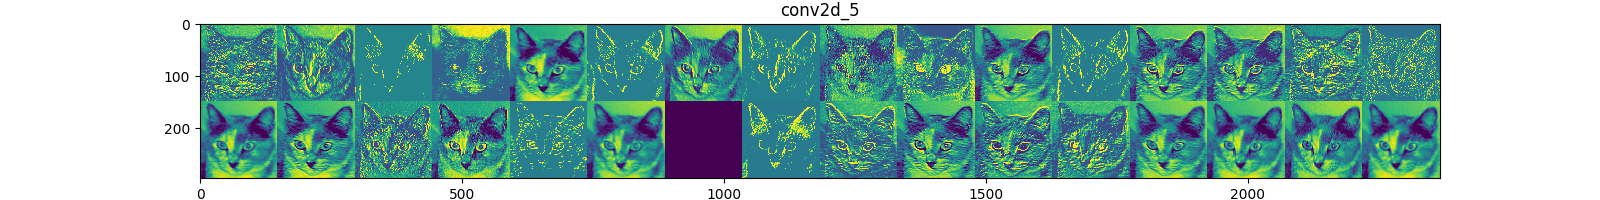

<IPython.core.display.Javascript object>


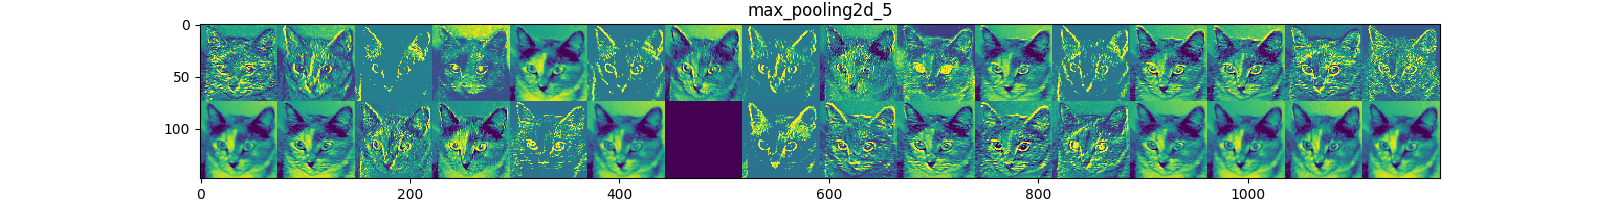

<IPython.core.display.Javascript object>


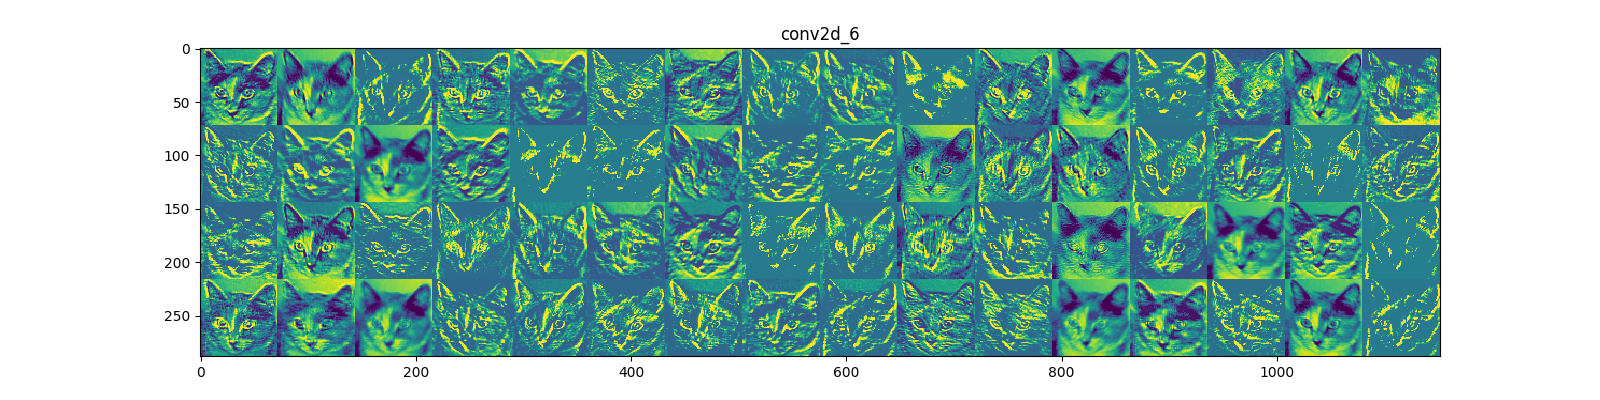

<IPython.core.display.Javascript object>


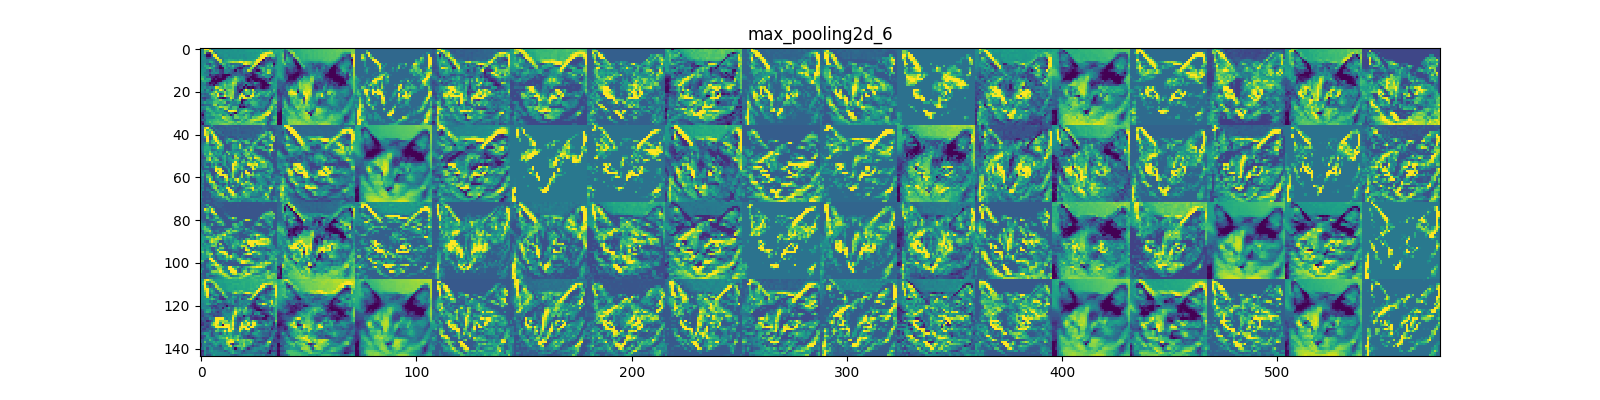

<IPython.core.display.Javascript object>


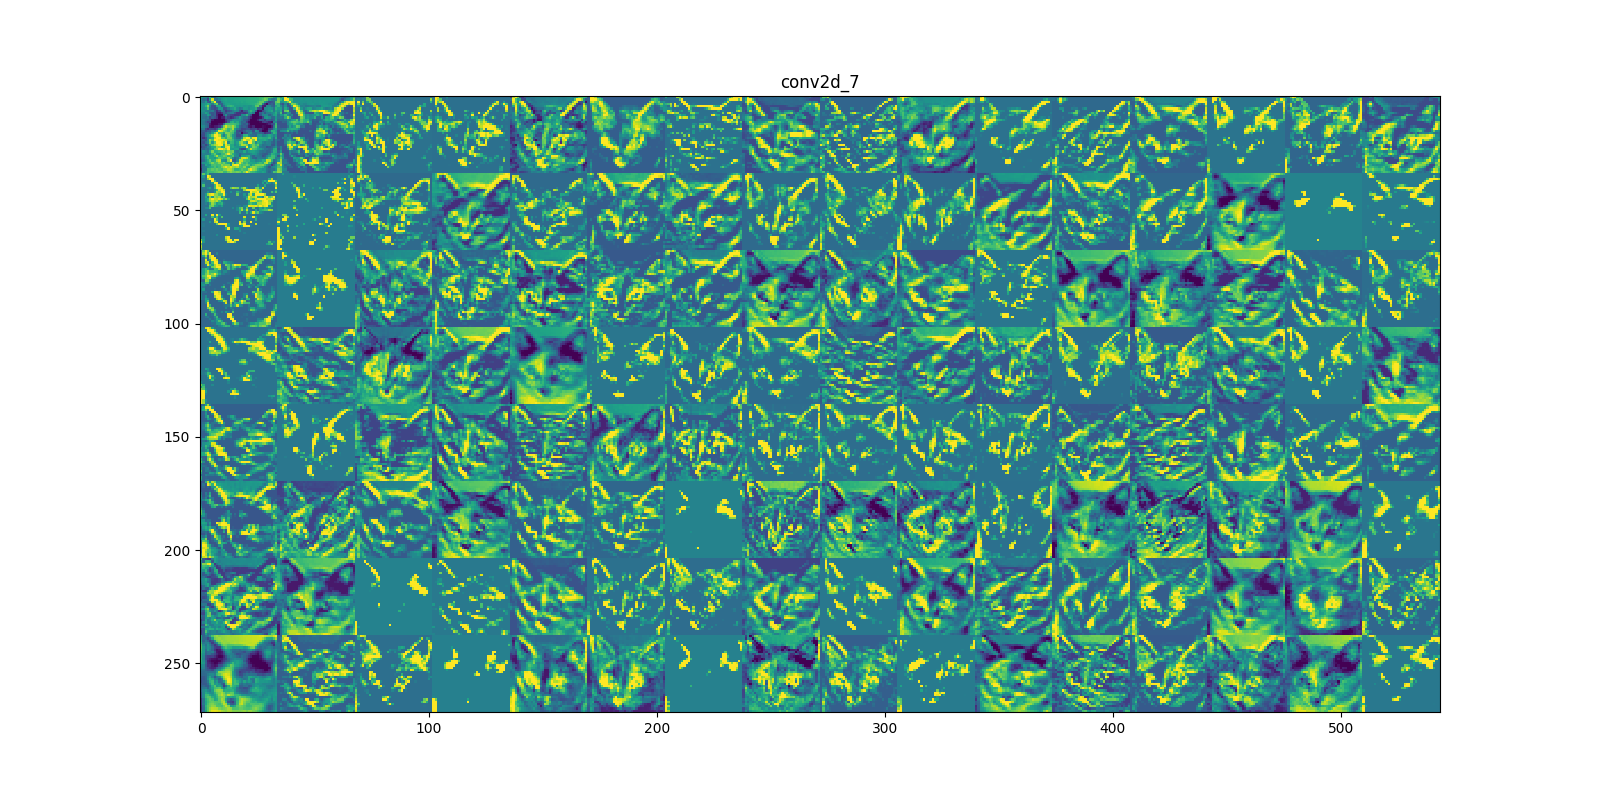

<IPython.core.display.Javascript object>


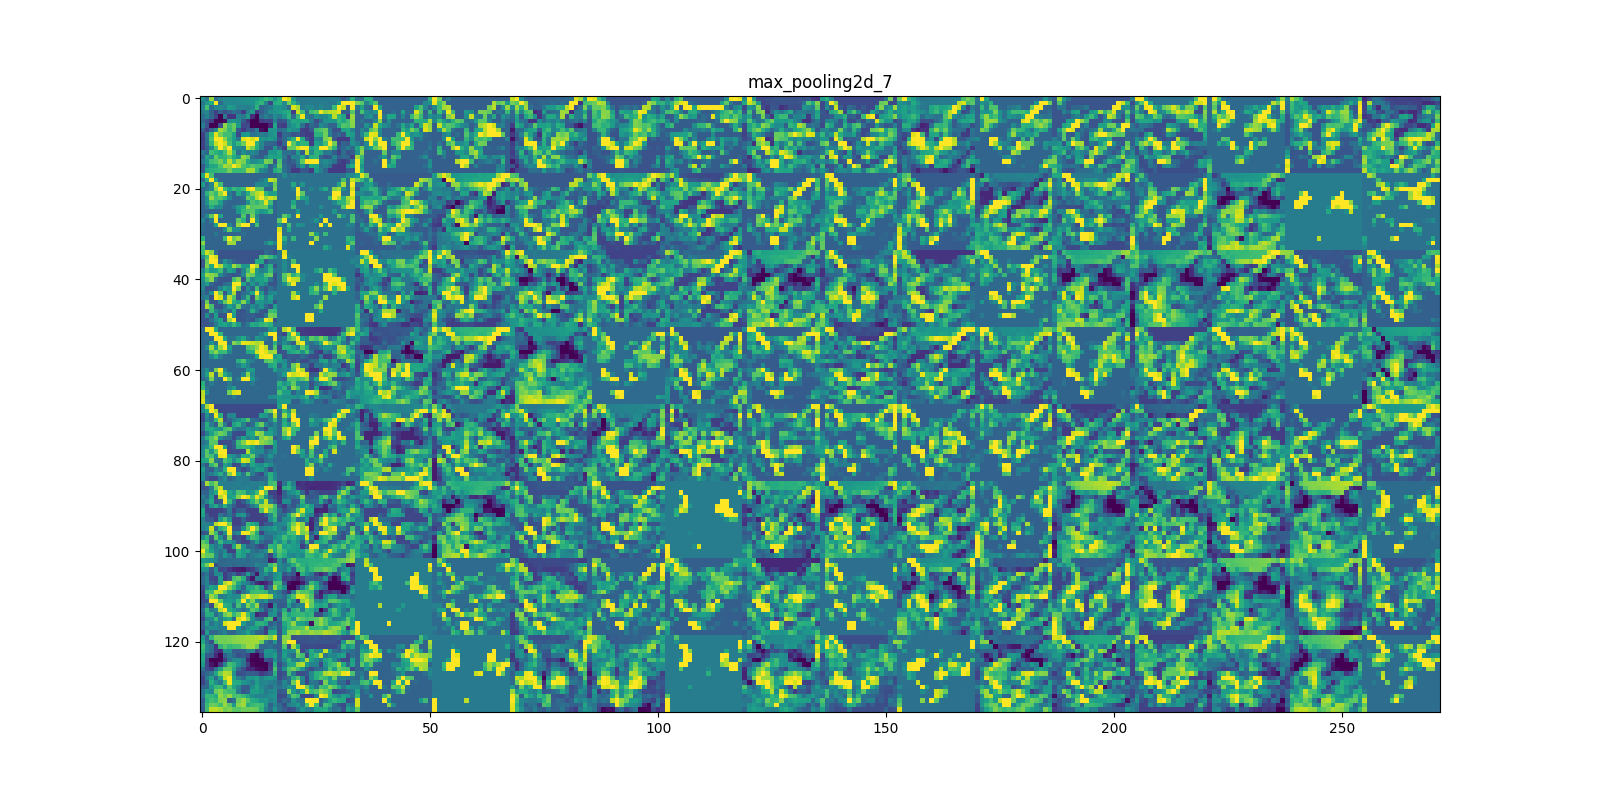

<IPython.core.display.Javascript object>


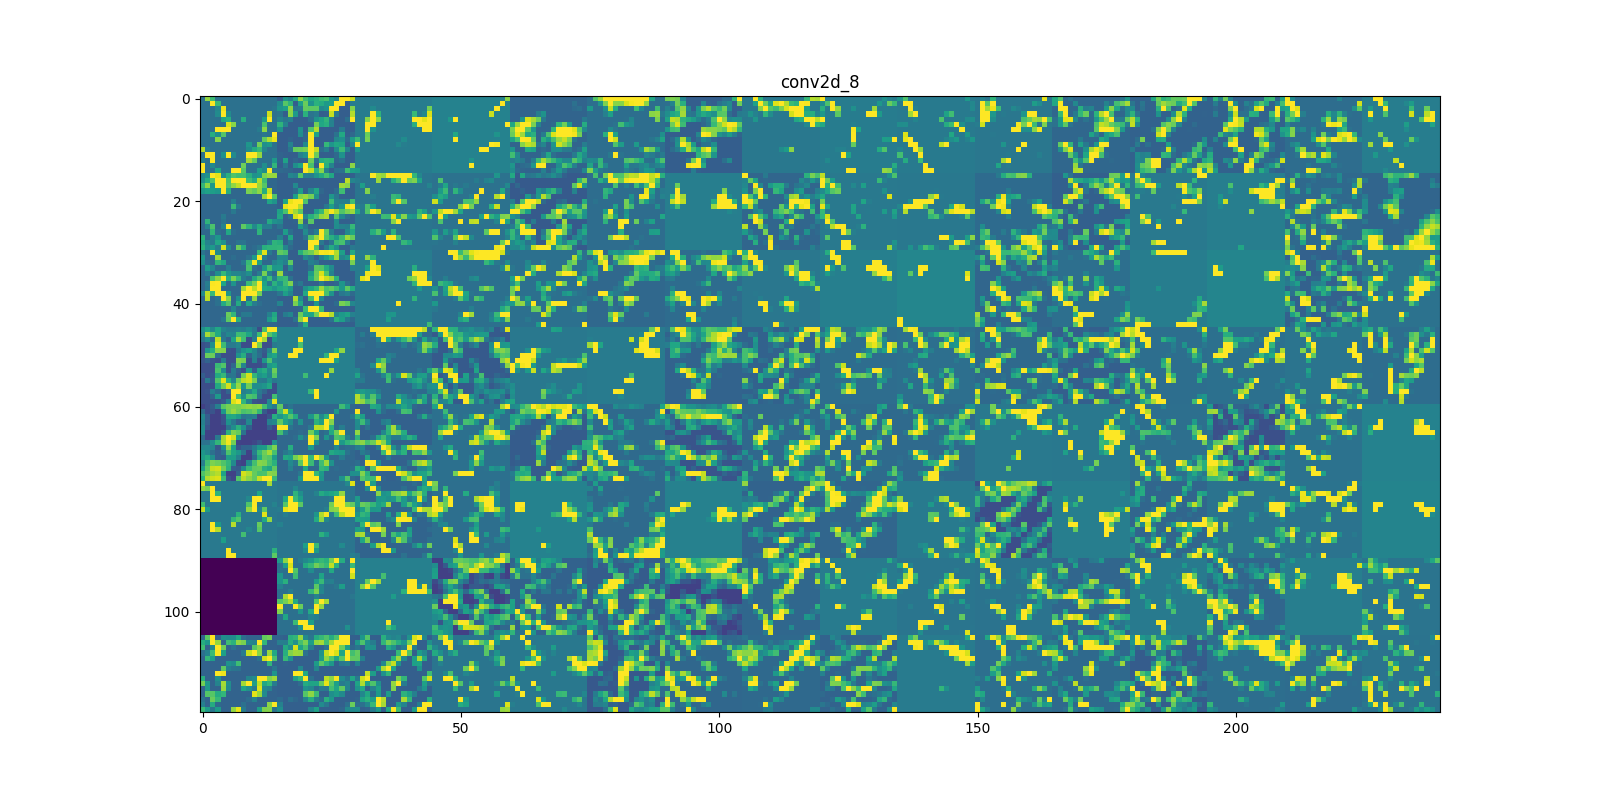

<IPython.core.display.Javascript object>


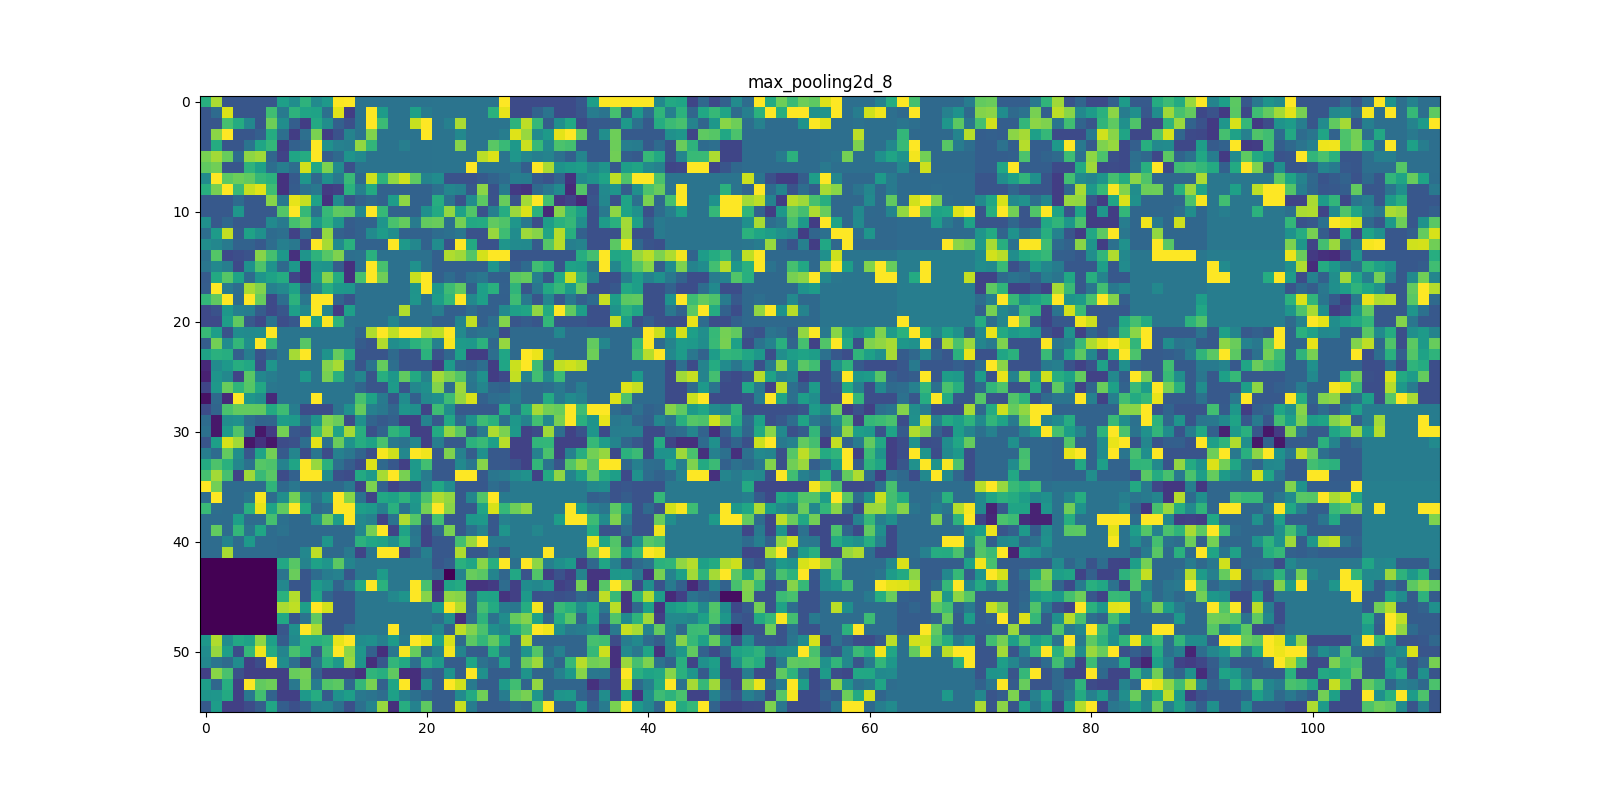

In [9]:
%matplotlib notebook
# Listing 5.31 Visualizing every channel in every intermediate activation
layer_names = []

# extract layer names
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16                                                   # layer_name: str
for layer_name, layer_activation in zip(layer_names, activations):    # layer_activation: tensor of shape (1, 148, 148, 32) or (I, size, size, n_features)
    
    n_features = layer_activation.shape[-1]      
    size = layer_activation.shape[1]                      
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        
        for row in range(images_per_row):
            
            channel_image = layer_activation[0,
                                            :, :,
                                            col*images_per_row + row]
                                            
            # post-processing the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
    
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        
            display_grid[col*size : (col+1)*size,
                         row*size : (row+1)*size] = channel_image
            
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],
                       scale*display_grid.shape[0]))
    
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect="auto", cmap="viridis")
    plt.show()
    

**Note** The last block (`max_pooling2d_8`) contains the features extracted by the network. These features can then be used for classification. To this end, the features are transformed into a vector (`Flatten` layer) of shape `(6272, )`, meaning that the network extracts 6272 features. These attributes are then employed as input for a densely-connected network (last two layers: `dense_3` and `dense_4`):

In [8]:
# load model v1: small dataset
model = load_model('dogs_vs_cats_v1.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

Notice how the shape of each layer decreases as the depth increases:

In [12]:
%matplotlib notebook
# Listing 5.31 Visualizing every channel in every intermediate activation
layer_names = []

# extract layer names
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16                                                   # layer_name: str
for layer_name, layer_activation in zip(layer_names, activations):    # layer_activation: tensor of shape (1, 148, 148, 32) or (I, size, size, n_features)
    
    
    print("name:  %s" % layer_name)
    print("shape: %s" % (layer_activation.shape, ))
    print("")

name:  conv2d_5
shape: (1, 148, 148, 32)

name:  max_pooling2d_5
shape: (1, 74, 74, 32)

name:  conv2d_6
shape: (1, 72, 72, 64)

name:  max_pooling2d_6
shape: (1, 36, 36, 64)

name:  conv2d_7
shape: (1, 34, 34, 128)

name:  max_pooling2d_7
shape: (1, 17, 17, 128)

name:  conv2d_8
shape: (1, 15, 15, 128)

name:  max_pooling2d_8
shape: (1, 7, 7, 128)



There are a few things to note here:

- The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
- As you go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode **higher-level concepts** such as *cat ear* and *cat eye*. Higher representations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
- The sparsity of the activation increases with the depth of the layer: in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank. This means the pattern encoded by the filter is not found in the input image.

We have just evidenced an important universal characteristic of the representaions learned by deep neural networks: the features extracted by a layer become increasingly abstract with the depth of the layer.

The activations of higher layers carry less and less information about the specific input being seen, and more and more information about the target (in this case, the class of the image: cat or dog). A deep neural network effectively acts as an **information distillation pipeline**, with raw data going in (in this case, RGB pictures) and being repeatedly transformed so that irrelevant information is filtered out (for example, the specific visual appearance of the image), and useful information is magnified and refined (for example, the class of the image).

This is analogous 